In [7]:
!ipython nbconvert --to script lobster_landmarks_localization_vgg16_attention-wing-loss-tangier-staged2-demo.ipynb

[TerminalIPythonApp] WARNING | Subcommand `ipython nbconvert` is deprecated and will be removed in future versions.
[TerminalIPythonApp] WARNING | You likely want to use `jupyter nbconvert` in the future
[NbConvertApp] Converting notebook lobster_landmarks_localization_vgg16_attention-wing-loss-tangier-staged2-demo.ipynb to script
[NbConvertApp] Writing 12932 bytes to lobster_landmarks_localization_vgg16_attention-wing-loss-tangier-staged2-demo.py


In [8]:
!python lobster_landmarks_localization_vgg16_attention-wing-loss-tangier-staged2-demo.py -i /tf/data/tangier-visit2/DSC_0497.JPG

Using TensorFlow backend.
2019-04-04 11:06:27.339476: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2019-04-04 11:06:27.355049: I tensorflow/stream_executor/platform/default/dso_loader.cc:42] Successfully opened dynamic library libcuda.so.1
2019-04-04 11:06:27.444643: W tensorflow/compiler/xla/service/platform_util.cc:256] unable to create StreamExecutor for CUDA:0: failed initializing StreamExecutor for CUDA device ordinal 0: Internal: failed call to cuDevicePrimaryCtxRetain: CUDA_ERROR_OUT_OF_MEMORY: out of memory; total memory reported: 6373572608
2019-04-04 11:06:27.444736: F tensorflow/stream_executor/lib/statusor.cc:34] Attempting to fetch value instead of handling error Internal: no supported devices found for platform CUDA
Aborted (core dumped)


In [220]:
import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
import os

from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D,MaxPooling2D,Flatten,Conv1D,Softmax
from keras.preprocessing import sequence

from sklearn.model_selection import train_test_split


import json
import numpy as np
import pandas as pd
from sklearn import preprocessing
import keras
from keras.layers import Input,Dense,Lambda,RepeatVector,Dot
from keras.models import Model
import os
import numpy as np
from keras.preprocessing import image as image_p
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.vgg16 import VGG16
import time
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import pickle
import matplotlib.image as mpimg
from keras.preprocessing import image
from  matplotlib import pyplot
from keras.layers.normalization import BatchNormalization
import cv2
import seaborn as sns
import random
from PIL import Image
from sklearn.utils import class_weight
from keras.layers import Reshape,merge,Concatenate,Add,Dropout
import keras.backend as K
import math
from keras.activations import softmax,tanh
import tensorflow as tf
from keras.applications.vgg16 import VGG16


#import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
import os
from sklearn.model_selection import train_test_split


import json
import numpy as np
import pandas as pd
from sklearn import preprocessing
import os
import numpy as np
from sklearn.model_selection import train_test_split
import pickle
import matplotlib.image as mpimg
from  matplotlib import pyplot
import cv2
import random
from PIL import Image
from sklearn.utils import class_weight
import numpy
import codecs

import xmltodict, json

import imgaug as ia
from imgaug import augmenters as iaa
import math
from keras.callbacks import ModelCheckpoint

In [221]:
def transform_images_landmarks(images,landmarks,bboxes):
    new_landmarks = []
    new_images = []
    corr = []
    for img,bb,landmark in zip(images,bboxes,landmarks):
        xmin,ymin,xmax,ymax = bb
        if xmin<0:
            xmin = 0
        if ymin<0:
            ymin = 0
        #print("asd",img.shape)
        #print(int(xmax)-int(xmin),int(ymax)-int(ymin))
        img = img[int(ymin):int(ymax),int(xmin):int(xmax),:]
        #print(xmin,xmax,ymin,ymax)
        #print("cccc",img.shape)
        new_mark = []
        for i in range(11):
            a,b = landmark[i*2],landmark[i*2+1]
            a = a - xmin
            b = b - ymin
            new_mark.append((a,b))
        img,new_mark,corrections = process_image_keypoints(img,new_mark)
        new_landmarks.append(np.array(new_mark))
        new_images.append(img)
        corr.append(corrections)
    return new_images,new_landmarks,corr

In [222]:
def load(path):
    """takes as input the path to a .pts and returns a list of 
    tuples of floats containing the points in in the form:
    [(x_0, y_0, z_0),
     (x_1, y_1, z_1),
    ...
     (x_n, y_n, z_n)]"""
    with codecs.open(path, 'r', encoding='utf-8') as f:
        rows = [rows.strip() for rows in f]
    
    """Use the curly braces to find the start and end of the point data""" 
    head = rows.index('{') + 1
    tail = rows.index('}')

    """Select the point data split into coordinates"""
    raw_points = rows[head:tail]
    coords_set = [point.split() for point in raw_points]

    """Convert entries from lists of strings to tuples of floats"""
    points = [tuple([float(point) for point in coords]) for coords in coords_set]
    return points
def process_image_keypoints(img,rectangle_points,bbox_coords):
    desired_size = 224

    old_size = img.shape

    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])

    # new_size should be in (width, height) format

    im = cv2.resize(img, (new_size[1], new_size[0]))

    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)

    color = [0, 0, 0]
    new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT,
        value=color)

    point_list = rectangle_points
    rects = []
    for a,b in point_list:
        a = a*ratio
        b = b*ratio
        rects.append([a+left,b+top])
    bbox_coordinates = []
    for a,b in bbox_coords:
        a = float(a)*ratio
        b = float(b)*ratio
        bbox_coordinates.append([a+left,b+top])
    return new_im,rects,bbox_coordinates
def process_image_keypoints_nobox(img,rectangle_points):
    desired_size = 224

    old_size = img.shape

    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])

    # new_size should be in (width, height) format

    im = cv2.resize(img, (new_size[1], new_size[0]))

    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)

    color = [0, 0, 0]
    new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT,
        value=color)

    point_list = rectangle_points
    rects = []
    for a,b in point_list:
        a = a*ratio
        b = b*ratio
        rects.append([a+left,b+top])
    return new_im,rects

def process_image_keypoints_coords(img,bbox_coords):
    desired_size = 224

    old_size = img.shape

    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])

    # new_size should be in (width, height) format

    im = cv2.resize(img, (new_size[1], new_size[0]))

    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)

    color = [0, 0, 0]
    new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT,
        value=color)

    bbox_coordinates = []
    for a,b in bbox_coords:
        a = float(a)*ratio
        b = float(b)*ratio
        bbox_coordinates.append([a+left,b+top])
    return new_im,bbox_coordinates
# !pip install keras
#num_labels = len(np.unique(labels))

def process_image_keypoints_nobox_util(img):
    desired_size = 224

    old_size = img.shape

    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])

    # new_size should be in (width, height) format

    im = cv2.resize(img, (new_size[1], new_size[0]))

    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)

    color = [0, 0, 0]
    new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT,
        value=color)

    return new_im,[left,top,ratio]

def iou_metric(y_true, y_pred):
    # iou as metric for bounding box regression
    # input must be as [x1, y1, x2, y2]
    
    # AOG = Area of Groundtruth box
    AoG = K.abs(K.transpose(y_true)[2] - K.transpose(y_true)[0] + 1) * K.abs(K.transpose(y_true)[3] - K.transpose(y_true)[1] + 1)
    
    # AOP = Area of Predicted box
    AoP = K.abs(K.transpose(y_pred)[2] - K.transpose(y_pred)[0] + 1) * K.abs(K.transpose(y_pred)[3] - K.transpose(y_pred)[1] + 1)

    # overlaps are the co-ordinates of intersection box
    overlap_0 = K.maximum(K.transpose(y_true)[0], K.transpose(y_pred)[0])
    overlap_1 = K.maximum(K.transpose(y_true)[1], K.transpose(y_pred)[1])
    overlap_2 = K.minimum(K.transpose(y_true)[2], K.transpose(y_pred)[2])
    overlap_3 = K.minimum(K.transpose(y_true)[3], K.transpose(y_pred)[3])

    # intersection area
    intersection = (overlap_2 - overlap_0 + 1) * (overlap_3 - overlap_1 + 1)

    # area of union of both boxes
    union = AoG + AoP - intersection
    
    # iou calculation
    iou = intersection / union

    # bounding values of iou to (0,1)
    iou = K.clip(iou, 0.0 + K.epsilon(), 1.0 - K.epsilon())

    return iou   

from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
class CustomModelCheckpoint(ModelCheckpoint):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.epochs_since_last_save += 1
        if self.epochs_since_last_save >= self.period:
            self.epochs_since_last_save = 0
            filepath = self.filepath.format(epoch=epoch + 1, **logs)
            if self.save_best_only:
                current = logs.get(self.monitor)
                if current is None:
                    warnings.warn('Can save best model only with %s available, '
                                  'skipping.' % (self.monitor), RuntimeWarning)
                else:
                    if self.monitor_op(current, self.best):
                        if self.verbose > 0:
                            print('\nEpoch %05d: %s improved from %0.5f to %0.5f,'
                                  ' saving model to %s'
                                  % (epoch + 1, self.monitor, self.best,
                                     current, filepath))
                        self.best = current
                        if self.save_weights_only:
                            #self.model.save_weights(filepath, overwrite=True)
                            print("asd")
                            try:
                                with open(filepath,'wb') as f:
                                    pickle.dump(self.model.get_weights(),f)
                            except Exception as ex:
                                print("Could not write",ex)
                        else:
                            self.model.save(filepath, overwrite=True)
                    else:
                        if self.verbose > 0:
                            print('\nEpoch %05d: %s did not improve from %0.5f' %
                                  (epoch + 1, self.monitor, self.best))
            else:
                if self.verbose > 0:
                    print('\nEpoch %05d: saving model to %s' % (epoch + 1, filepath))
                if self.save_weights_only:
                    self.model.save_weights(filepath, overwrite=True)
                else:
                    self.model.save(filepath, overwrite=True)

In [223]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9694580738653291482, name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 168662322749573414
 physical_device_desc: "device: XLA_GPU device", name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 16380391393750253729
 physical_device_desc: "device: XLA_CPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 5803671552
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 15877334321377139535
 physical_device_desc: "device: 0, name: GeForce GTX 1060 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1"]

In [7]:
count_correct = 0
count_wrong = 0
images = []
bboxes = []
image_sizes = []
image_names = []
for file in os.listdir("/tf/data/gender_annotations/"):
    try:
        with open('/tf/data/gender_annotations/'+file,'r') as f:
            text = f.read()
            d = xmltodict.parse(text)
        path = d['annotation']['path']
        rel_path = "/home/parmeet1992/Pictures/"
        
        path = path.split(rel_path)[1]
        path = "/tf/data/" + path
        bgr_img = cv2.imread(path)
        img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
        
        obj = d['annotation']['object'][0] if isinstance(d['annotation']['object'],list) else d['annotation']['object']
        bbox = obj['bndbox']                
        bbox_coords = [(bbox['xmin'],bbox['ymin']),(bbox['xmax'],bbox['ymax'])]


        img,bbox_coords = process_image_keypoints_coords(img,bbox_coords)
        bbs = ia.BoundingBoxesOnImage([
            ia.BoundingBox(x1=bbox_coords[0][0], y1=bbox_coords[0][1], x2=bbox_coords[1][0], y2=bbox_coords[1][1])
        ], shape=img.shape)

        images.append(img)
        bboxes.append(bbs)
        count_correct += 1
    except Exception as ex:
        print(ex)
        count_wrong += 1

OpenCV(4.0.0) /io/opencv/modules/imgproc/src/color.cpp:181: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

OpenCV(4.0.0) /io/opencv/modules/imgproc/src/color.cpp:181: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

OpenCV(4.0.0) /io/opencv/modules/imgproc/src/color.cpp:181: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

OpenCV(4.0.0) /io/opencv/modules/imgproc/src/color.cpp:181: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

OpenCV(4.0.0) /io/opencv/modules/imgproc/src/color.cpp:181: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

OpenCV(4.0.0) /io/opencv/modules/imgproc/src/color.cpp:181: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

OpenCV(4.0.0) /io/opencv/modules/imgproc/src/color.cpp:181: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

OpenCV(4.0.0) /io/opencv/modules/imgproc/src/color.cpp:181: error: (-215:Assertion failed) !_src.

OpenCV(4.0.0) /io/opencv/modules/imgproc/src/color.cpp:181: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

OpenCV(4.0.0) /io/opencv/modules/imgproc/src/color.cpp:181: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

OpenCV(4.0.0) /io/opencv/modules/imgproc/src/color.cpp:181: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

OpenCV(4.0.0) /io/opencv/modules/imgproc/src/color.cpp:181: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

OpenCV(4.0.0) /io/opencv/modules/imgproc/src/color.cpp:181: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

OpenCV(4.0.0) /io/opencv/modules/imgproc/src/color.cpp:181: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

OpenCV(4.0.0) /io/opencv/modules/imgproc/src/color.cpp:181: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

OpenCV(4.0.0) /io/opencv/modules/imgproc/src/color.cpp:181: error: (-215:Assertion failed) !_src.

In [5]:
sometimes = lambda aug: iaa.Sometimes(0.5, aug)
seq = iaa.Sequential(
    [
        # apply the following augmenters to most images
        iaa.Fliplr(0.5), # horizontally flip 50% of all images
        iaa.Flipud(0.5), # vertically flip 50% of all images
        sometimes(iaa.Affine(
            #scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
            translate_percent={"x": (-0.15, 0.15), "y": (-0.15, 0.15)}, # translate by -20 to +20 percent (per axis)
            rotate=(-45, 45), # rotate by -45 to +45 degrees
            order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
            cval=(0, 255), # if mode is constant, use a cval between 0 and 255
            mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        )),
        # execute 0 to 5 of the following (less important) augmenters per image
        # don't execute all of them, as that would often be way too strong
        iaa.SomeOf((0, 5),
            [
                #iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)), # sharpen images
                #iaa.Add((-10, 10), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
                iaa.ContrastNormalization((0.9, 1.10), per_channel=0.5), # improve or worsen the contrast
            ],
            random_order=True
        )
    ],
    random_order=True
)

In [6]:
def augment_images_bboxes(images,bboxes,times):
    all_bboxes = []
    
    
    images = [(x[:,:,:] * 255.0).astype(np.uint8) for x in images]
    all_images = list(images)
    
    for bbs in bboxes:
            all_bboxes.append(np.array([bbs.bounding_boxes[0].x1,bbs.bounding_boxes[0].y1,bbs.bounding_boxes[0].x2,bbs.bounding_boxes[0].y2]))
    #print(len(all_images))
    #print(len(all_bboxes))
    
    for i in range(times):
        seq_det = seq.to_deterministic()
        image_aug = seq_det.augment_images(images)
        bbs_aug = seq_det.augment_bounding_boxes(bboxes)
        for bbs in bbs_aug:
            all_bboxes.append(np.array([bbs.bounding_boxes[0].x1,bbs.bounding_boxes[0].y1,bbs.bounding_boxes[0].x2,bbs.bounding_boxes[0].y2]))
        
        all_images = all_images + list(image_aug)
        #all_image_sizes = all_image_sizes + list(image_sizes)
    all_images = [(x[:,:,:] / 255.0).astype(np.float64) for x in all_images]
    return all_images,all_bboxes

In [122]:
def wing_loss(landmarks, labels, w=10.0, epsilon=2.0):
    """
    Arguments:
        landmarks, labels: float tensors with shape [batch_size, num_landmarks, 2].
        w, epsilon: a float numbers.
    Returns:
        a float tensor with shape [].
    """
    with tf.name_scope('wing_loss'):
        x = landmarks - labels
        c = w * (1.0 - math.log(1.0 + w/epsilon))
        absolute_x = tf.abs(x)
        losses = tf.where(
            tf.greater(w, absolute_x),
            w * tf.log(1.0 + absolute_x/epsilon),
            absolute_x - c
        )
        loss = tf.reduce_mean(tf.reduce_sum(losses, axis=[1]), axis=0)
        return loss

In [123]:
X_normalized = [(x[:,:,:].astype(np.float64)) / 255.0 for x in images]
X_train, X_test, y_train, y_test = train_test_split(X_normalized,bboxes,test_size=0.33,random_state=42,shuffle=True)
test_bboxes = []
for bbs in list(y_test):
    test_bboxes.append(np.array([bbs.bounding_boxes[0].x1,bbs.bounding_boxes[0].y1,bbs.bounding_boxes[0].x2,bbs.bounding_boxes[0].y2]))
train_images,train_bboxes = augment_images_bboxes(X_train,y_train,3)

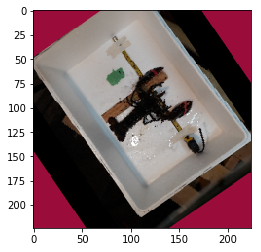

In [176]:
idx = idx + 1
plt.imshow(train_images[-1-idx])

In [224]:
cnn_base = VGG16(input_shape=(224,224,3),include_top=False,weights='imagenet')

for layer in cnn_base.layers:
    if layer.name=='block5_conv3':
        break
    layer.trainable = False

x = cnn_base.get_layer('block5_pool').output
x = Conv2D(64, kernel_size=(3, 3), padding="same")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = BatchNormalization()(x)
x = Conv2D(64, kernel_size=(3, 3), padding="same")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = BatchNormalization()(x)
x = Conv2D(4, kernel_size=(1, 1), padding="same")(x)
x = Reshape((4,),name='localization_output')(x)


model = Model(inputs=cnn_base.input, outputs=x)
sgd = keras.optimizers.SGD(lr=0.0000001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss="mean_squared_error", optimizer="adam", metrics=['accuracy',iou_metric])
initial_weights = model.get_weights()

In [225]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [226]:
try:
    with open('vgg16-landmark-box-weights1.hd5','rb') as f:
        model_weights = pickle.load(f)
        model.set_weights(model_weights)
        print("loaded weights")
except:
    print("not present")
checkpoint = CustomModelCheckpoint('vgg16-landmark-box-weights1.hd5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True,mode='min')
callbacks_list = [checkpoint]
history = model.fit(np.array(train_images),np.array(train_bboxes),validation_data=(np.array(X_test),np.array(test_bboxes)),epochs=30,batch_size=5,callbacks=callbacks_list)

loaded weights


NameError: name 'train_images' is not defined

In [227]:
with open('vgg16-landmark-box-weights1.hd5','rb') as f:
    model_weights = pickle.load(f)
    model.set_weights(model_weights)
    print("loaded weights")

loaded weights


In [228]:
count_correct = 0
count_wrong = 0
labels =  []
images = []
bb = []
bboxes = []
image_sizes = []
image_names = []
bb_sizes = []
landmarks =  []
for file in os.listdir("/tf/data//landmark_points/"):
    try:
        if file.endswith(".pts"):
                image_name = file.split("_imglab.pts")[0]
                path = '/tf/data/tangier-visit2/'+image_name
                if image_name.split("_")[0]!='DSC':
                    continue
                print(image_name.split("_")[0])
                bgr_img = cv2.imread(path)
                print(path)
                img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
                path = '/tf/data//landmark_points/'+file
                points = load(path)
                print(path)
                print('/tf/data/landmark_points_bboxes/'+file)
                
                img_temp,corr = process_image_keypoints_nobox_util(img)
                img_temp = (img_temp[:,:,:] / 255.0).astype(np.float64)
                [[xmin,ymin,xmax,ymax]] = model.predict(np.expand_dims(img_temp,0))
                [left,top,ratio] = corr
                xmin,xmax = (xmin - left)/ratio,(xmax - left)/ratio
                ymin,ymax = (ymin - top)/ratio,(ymax - top)/ratio            

                img = img[int(ymin):int(ymax),int(xmin):int(xmax),:]
                
                bbox_keypoints = []
                for x,y in points:
                        bbox_keypoints.append((x-xmin,y-ymin))
                image_temp,rectange_points = process_image_keypoints_nobox(img,bbox_keypoints)
            
            
                keypoints = []
                for x,y in rectange_points[4:10]:
                    keypoints.append(ia.Keypoint(x=x, y=y))
                print(len(keypoints))
                if len(keypoints)!=6:
                    continue
#                 bbs = ia.BoundingBoxesOnImage([
#                     ia.BoundingBox(x1=bbox_coords[0][0], y1=bbox_coords[0][1], x2=bbox_coords[1][0], y2=bbox_coords[1][1])
#                 ], shape=img.shape)
                images.append(image_temp)
                #bboxes.append(bbs)
                landmarks.append(ia.KeypointsOnImage(keypoints, shape=image_temp.shape))
                image_names.append(file)
                #labels.append(obj['name'])
                #bb_sizes.append((w,h))
                #bboxes_rot.append([w,h,cx,cy,angle])
                #image_sizes.append((float(d['annotation']['size']['width']),float(d['annotation']['size']['height'])))
                count_correct += 1
    except Exception as ex:
       print(ex)
       count_wrong += 1

DSC
/tf/data/tangier-visit2/DSC_0494.JPG
/tf/data//landmark_points/DSC_0494.JPG_imglab.pts
/tf/data/landmark_points_bboxes/DSC_0494.JPG_imglab.pts
6
DSC
/tf/data/tangier-visit2/DSC_0501.JPG_imglab(1).pts
OpenCV(4.0.0) /io/opencv/modules/imgproc/src/color.cpp:181: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

DSC
/tf/data/tangier-visit2/DSC_0498.JPG
/tf/data//landmark_points/DSC_0498.JPG_imglab.pts
/tf/data/landmark_points_bboxes/DSC_0498.JPG_imglab.pts
6
DSC
/tf/data/tangier-visit2/DSC_0491.JPG
/tf/data//landmark_points/DSC_0491.JPG_imglab.pts
/tf/data/landmark_points_bboxes/DSC_0491.JPG_imglab.pts
6
DSC
/tf/data/tangier-visit2/DSC_0495.JPG
/tf/data//landmark_points/DSC_0495.JPG_imglab.pts
/tf/data/landmark_points_bboxes/DSC_0495.JPG_imglab.pts
6
DSC
/tf/data/tangier-visit2/DSC_0493.JPG
/tf/data//landmark_points/DSC_0493.JPG_imglab.pts
/tf/data/landmark_points_bboxes/DSC_0493.JPG_imglab.pts
6
DSC
/tf/data/tangier-visit2/DSC_0490.JPG
/tf/data//landmark_points/DSC_

In [157]:
np.max(landmarks)

TypeError: unorderable types: KeypointsOnImage() >= KeypointsOnImage()

W0403 02:44:23.471691 140143605946112 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4
[array([180.32895952,  43.93055654, 187.74617807,  58.02327178,
        96.51438999,  91.40075522, 115.7991582 , 120.99545721,
        28.27597939, 139.61267575,  44.59386019, 167.79810621]), array([191.02767369, 112.82088247, 187.36275223, 128.28685105,
        97.20568416,  98.23449503,  94.27374699, 130.48580393,
        18.0433805 ,  90.9046521 ,  18.0433805 , 127.55386676]), array([ 44.77511594,  28.28471877,  60.57625803,  20.7603654 ,
        74.1200941 , 119.32939462, 107.22724896, 106.53799388,
       107.22724896, 200.59241108, 141.08683915, 184.03883365]), array([ 95.78349354,  18.1947209 , 111.22162941,  16.72442224,
        89.16714959, 110.82353613, 125.18946663, 110.82353613,
        91.37259757, 197.57115674, 125.92461595, 195.36570875]), array([116.06069776, 197.38645667,  98.04089578, 200.8518032 ,
       117.44683638, 110.059724  ,  86.95178687, 112.06962499,
       112.59535123,  37.28744677,  82.79337103,  39.99041707]), array([ 34.08693492, 175.83506842,  23.284

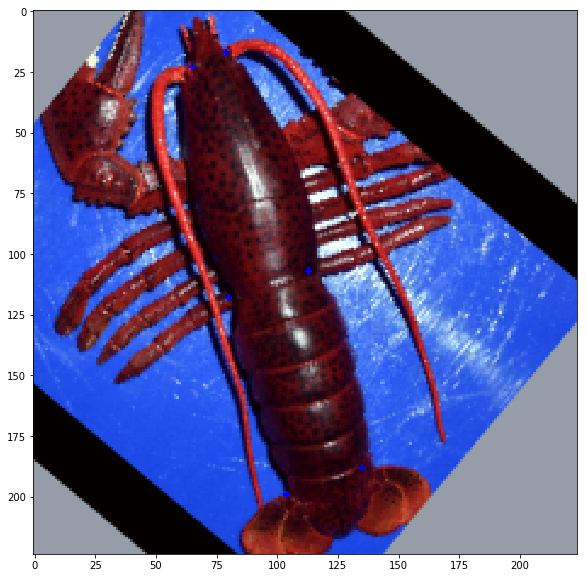

In [232]:
idx = idx + 1
# print(idx)
# pt1 = (int(bboxes[idx].bounding_boxes[0].x1),int(bboxes[idx].bounding_boxes[0].y1))
# pt2 = (int(bboxes[idx].bounding_boxes[0].x2),int(bboxes[idx].bounding_boxes[0].y2))
# print(pt1)
# print(pt2)
print(len(test_landmarks))
bbs = all_landmarks
tuples = []
for i in range(6):
    tuples.append((bbs[idx][i*2],bbs[idx][i*2+1]))
for i in range(6):
     img = cv2.circle(all_images[idx],(int(tuples[i][0]),int(tuples[i][1])), 1, (0,0,255), -1)

plt.figure(figsize=(10,10))
plt.imshow(img)
print(all_landmarks)

In [213]:
sometimes = lambda aug: iaa.Sometimes(0.5, aug)
seq = iaa.Sequential(
    [
        # apply the following augmenters to most images
        iaa.Fliplr(0.5), # horizontally flip 50% of all images
        iaa.Flipud(0.5), # vertically flip 50% of all images
        sometimes(iaa.Affine(
            #scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
            translate_percent={"x": (-0.15, 0.15), "y": (-0.15, 0.15)}, # translate by -20 to +20 percent (per axis)
            rotate=(-45, 45), # rotate by -45 to +45 degrees
            order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
            cval=(0, 255), # if mode is constant, use a cval between 0 and 255
            mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        )),
        # execute 0 to 5 of the following (less important) augmenters per image
        # don't execute all of them, as that would often be way too strong
        iaa.SomeOf((0, 5),
            [
                #iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)), # sharpen images
                #iaa.Add((-10, 10), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
                iaa.ContrastNormalization((0.9, 1.10), per_channel=0.5), # improve or worsen the contrast
            ],
            random_order=True
        )
    ],
    random_order=True
)

In [229]:
def augment_images(images,landmarks,times,seq):
    all_landmarks = []
  #  all_bboxes = []
    images = [(x[:,:,:] * 255.0).astype(np.uint8) for x in images]
    all_images = list(images)
    #all_image_sizes = list(image_sizes)
    
    
    for landmark in landmarks:
            outputs = []
            for obj in landmark.keypoints:
                outputs.append(obj.x)
                outputs.append(obj.y)
            all_landmarks.append(np.array(outputs))
#     for bbs in bboxes:
#             all_bboxes.append(np.array([bbs.bounding_boxes[0].x1,bbs.bounding_boxes[0].y1,bbs.bounding_boxes[0].x2,bbs.bounding_boxes[0].y2]))

    for i in range(times):
        seq_det = seq.to_deterministic()
        image_aug = seq_det.augment_images(images)
        bbs_aug = seq_det.augment_keypoints(landmarks)
        for bbs in bbs_aug:
            outputs = []
            for obj in bbs.keypoints:
                outputs.append(obj.x)
                outputs.append(obj.y)
            all_landmarks.append(np.array(outputs))
        #bbs_aug = seq_det.augment_bounding_boxes(bboxes)
#         for bbs in bbs_aug:
#             all_bboxes.append(np.array([bbs.bounding_boxes[0].x1,bbs.bounding_boxes[0].y1,bbs.bounding_boxes[0].x2,bbs.bounding_boxes[0].y2]))

        all_images = all_images + list(image_aug)
        #all_image_sizes = all_image_sizes + list(image_sizes)
    all_images = [(x[:,:,:] / 255.0).astype(np.float64) for x in all_images]
    return all_images,all_landmarks

In [230]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=3,shuffle=False,random_state=100)
test_cvscores = []
validation_cvscores = []
fusion_model_info = []
kfold_data = []

images_temp = [(x[:,:,:] / 255.0).astype(np.float64) for x in images]
i = 0
for train, test in kf.split(images_temp):
    i = i + 1
    print(i)
    #all_images,all_landmarks,all_bboxes,all_image_sizes = augment_images(np.array(images_temp)[train],np.array(landmarks)[train],np.array(bboxes)[train],np.array(image_sizes)[train],2)
    all_images,all_landmarks = augment_images(np.array(images_temp)[train],np.array(landmarks)[train],200,seq)
    test_bboxes = []
    test_landmarks = []
    
#     for bbs in list(np.array(bboxes)[test]):
#         test_bboxes.append(np.array([bbs.bounding_boxes[0].x1,bbs.bounding_boxes[0].y1,bbs.bounding_boxes[0].x2,bbs.bounding_boxes[0].y2]))
    
    for bbs in list(np.array(landmarks)[test]):
            outputs = []
            for obj in bbs.keypoints:
                outputs.append(obj.x)
                outputs.append(obj.y)
            test_landmarks.append(np.array(outputs))
    kfold_data.append([all_images,all_landmarks,np.array(images_temp)[test],test_landmarks])

1
2
3


In [231]:
with open('lobster-data-localize-landmarks-tangier0.pckl','wb') as file:
    pickle.dump(kfold_data[0],file)
# with open('lobster-data-localize-landmarks-tangier1.pckl','wb') as file:
#     pickle.dump(kfold_data[1],file)
# with open('lobster-data-localize-landmarks-tangier2.pckl','wb') as file:
#     pickle.dump(kfold_data[2],file)
# with open('lobster-data-localize-landmarks-tangier3.pckl','wb') as file:
#     pickle.dump(kfold_data[3],file)
# with open('lobster-data-localize-landmarks-tangier4.pckl','wb') as file:
#     pickle.dump(kfold_data[4],file)

In [126]:
# for i in landmaks:
#     print(len(i.keypoints))
idx = idx + 1
len(all_images)

906

In [233]:
def attention_block(x,K,labels,w,h):
    H = Conv2D(K, kernel_size=(w, h), padding="same")(x)
    H = BatchNormalization()(H)
    spatial_softmax = Lambda(lambda x:softmax(H,axis=3))(H)
    O = Conv2D(labels*K, kernel_size=(w, h), padding="same")(x)
    O = BatchNormalization()(O)
    rH = Lambda(lambda x:keras.backend.repeat_elements(x, rep=labels, axis=3))(spatial_softmax)
    o = Lambda(lambda x: tf.einsum('bijk,bijk->bk',x[0],x[1]))([O,rH])
    tempH = Conv2D(K, kernel_size=(w, h), padding="same")(x)
    tempH = BatchNormalization()(tempH)
    gh = Lambda(lambda x: softmax(tanh(tf.einsum('bijk,bijk->bk',x[0],x[1])),axis=1))([tempH,spatial_softmax])
    rgh = Lambda(lambda x:keras.backend.repeat_elements(x, rep=labels, axis=1))(gh)
    of = Lambda(lambda x: tf.einsum('bk,bk->bk',x[0],x[1]))([rgh,o])
    new_shape = Reshape((labels,K))(of)
    out = Lambda(lambda x: keras.backend.sum(x,axis=2))(new_shape)
    #x = Conv2D(K, kernel_size=(w, h), padding="same")(x)
    #inter = Lambda(lambda x: Flatten()(keras.backend.mean(x,axis=3)))(x)
    inter = Conv2D(128, kernel_size=(w, h), padding="same")(x)
    inter = MaxPooling2D(pool_size=(2, 2))(inter)
    inter = BatchNormalization()(inter)
    inter = Conv2D(128, kernel_size=(w, h), padding="same")(inter)
    inter = MaxPooling2D(pool_size=(2, 2))(inter)
    inter = BatchNormalization()(inter)
    print(inter.shape)
    inter = Conv2D(1, kernel_size=(w, h), padding="same")(inter)
    inter = Flatten()(inter)
    weight = Dense(labels,activation='tanh')(inter)
    return out,weight

In [234]:
def wing_loss(landmarks, labels, w=10.0, epsilon=2.0):
    """
    Arguments:
        landmarks, labels: float tensors with shape [batch_size, num_landmarks, 2].
        w, epsilon: a float numbers.
    Returns:
        a float tensor with shape [].
    """
    with tf.name_scope('wing_loss'):
        x = landmarks - labels
        c = w * (1.0 - math.log(1.0 + w/epsilon))
        absolute_x = tf.abs(x)
        losses = tf.where(
            tf.greater(w, absolute_x),
            w * tf.log(1.0 + absolute_x/epsilon),
            absolute_x - c
        )
        loss = tf.reduce_mean(tf.reduce_sum(losses, axis=[1]), axis=0)
        return loss

In [235]:
K = 5
labels = 12
w,h = 3,3

cnn_base = VGG16(input_shape=(224,224,3),include_top=False,weights='imagenet')

for layer in cnn_base.layers:
    if layer.name=='block5_conv3':
        break
    layer.trainable = False

x = cnn_base.get_layer('block2_conv2').output
final4,weight4 = attention_block(x,K,labels,w,h)
#final1 = Lambda(lambda x: tf.einsum('bk,bk->bk',x[0],x[1]))([final1,weight1])
    

x = cnn_base.get_layer('block3_conv3').output
final1,weight1 = attention_block(x,K,labels,w,h)
#final1 = Lambda(lambda x: tf.einsum('bk,bk->bk',x[0],x[1]))([final1,weight1])

x = cnn_base.get_layer('block4_conv3').output
final2,weight2 = attention_block(x,K,labels,w,h)

#final2 = Lambda(lambda x: tf.einsum('bk,bk->bk',x[0],x[1]))([final2,weight2])

x = cnn_base.get_layer('block5_pool').output
inter = Lambda(lambda x: Flatten()(x[:,:,:,0]))(x)
weight3 = Dense(labels,activation='tanh')(inter)

x = Conv2D(64, kernel_size=(3, 3), padding="same")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = BatchNormalization()(x)
x = Conv2D(64, kernel_size=(3, 3), padding="same")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = BatchNormalization()(x)
x = Conv2D(labels, kernel_size=(1, 1), padding="same")(x)
x = Reshape((labels,),name='localization_output')(x)
#final3 = Lambda(lambda x: tf.einsum('bk,bk->bk',x[0],x[1]))([x,weight3])

#bag_of_models = Add()([final1,final2,final3])
# weight_concat = Concatenate()([weight1,weight2,weight4,weight3])
# weight_concat = Softmax()(weight_concat)
# final = Concatenate()([final1,final2,final4,x])

# final3 = Lambda(lambda x: tf.einsum('bk,bk->bk',x[0],x[1]))([weight_concat,final])
# final3 = Dense(22)(final3)

weight_concat = Concatenate()([weight1,weight2,weight3])
weight_concat = Reshape((labels,3))(weight_concat)
weight_concat = Softmax(axis=2)(weight_concat)

final = Concatenate()([final1,final2,x])
final = Reshape((labels,3))(final)


sum_final = Lambda(lambda x: tf.einsum('bij,bij->bij',x[0],x[1]))([weight_concat,final])
sum_final = Lambda(lambda x: keras.backend.sum(x,axis=2))(sum_final)
sum_final = Dense(labels)(sum_final)

model = Model(inputs=cnn_base.input, outputs=sum_final)
#sgd = keras.optimizers.SGD(lr=0.00001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss="mean_squared_error", optimizer="adam")
print(model.summary())
initial_weights = model.get_weights()

(?, 28, 28, 128)
(?, 14, 14, 128)
(?, 7, 7, 128)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_7[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
____________________________________________________________

In [237]:
train_pred = []
test_pred = []

train_scores = []
test_scores = []

history_record = []

In [238]:
idx = 0
plt.imshow(all_images[-1-idx])

In [239]:
for i in range(5):
    print("Loading file")
    with open('lobster-data-localize-landmarks-tangier'+str(i)+'.pckl','rb') as file:
        all_images,all_landmarks,test_images,test_landmarks = pickle.load(file)
    try:
        with open('lobster-landmarks_localization_vgg16_attention_wing_loss_tangierv13'+str(i)+'.hd5','rb') as f:
            model_weights = pickle.load(f)
            print("loaded model")
    except:
        print("setting initial weights")
        model_weights = initial_weights
    model.set_weights(model_weights)
    print("loaded")
    print(np.max(test_images[0]))
    checkpoint = CustomModelCheckpoint('lobster-landmarks_localization_vgg16_attention_wing_loss_tangierv13'+str(i)+'.hd5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True,mode='min')
    earlyStopping = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=12, verbose=0, mode='min', baseline=None, restore_best_weights=False)
    callbacks_list = [checkpoint,earlyStopping]
    history = model.fit(x=np.array(all_images),y=np.array(all_landmarks),batch_size=5,epochs=50,
                           validation_data=(np.array(test_images),np.array(test_landmarks)),callbacks=callbacks_list)
    history_record.append(history)
    train_score = model.evaluate(x=np.array(all_images),y=np.array(all_landmarks),batch_size=50)
    test_score = model.evaluate(x=np.array(test_images),y=np.array(test_landmarks),batch_size=50)
    train_scores.append(train_score)
    test_scores.append(test_score)

Loading file
setting initial weights
loaded
1.0
Train on 1608 samples, validate on 4 samples
Epoch 1/50
1608/1608 [==============================] - 46s 29ms/step - loss: 2672.2295 - val_loss: 1038.9084

Epoch 00001: val_loss improved from inf to 1038.90845, saving model to lobster-landmarks_localization_vgg16_attention_wing_loss_tangierv130.hd5
asd
Epoch 2/50
1608/1608 [==============================] - 33s 21ms/step - loss: 769.8796 - val_loss: 1649.6531

Epoch 00002: val_loss did not improve from 1038.90845
Epoch 3/50
1608/1608 [==============================] - 34s 21ms/step - loss: 593.1245 - val_loss: 415.5737

Epoch 00003: val_loss improved from 1038.90845 to 415.57370, saving model to lobster-landmarks_localization_vgg16_attention_wing_loss_tangierv130.hd5
asd
Epoch 4/50
1608/1608 [==============================] - 33s 21ms/step - loss: 416.2338 - val_loss: 273.4952

Epoch 00004: val_loss improved from 415.57370 to 273.49524, saving model to lobster-landmarks_localization_vgg16

KeyboardInterrupt: 

In [176]:
# #model.evaluate(x=np.array(all_images[0:5]),y=np.array(all_landmarks[0:5]),batch_size=5)
# #model.predict(x=np.array(all_images[0:5]),batch_size=5)
# print(len(landmarks))
# for obj in landmarks:
#     for i in range(6):
#         print(obj.keypoints[i].y)

In [241]:
i = 0
with open('lobster-data-localize-landmarks-tangier'+str(i)+'.pckl','rb') as file:
        all_images,all_landmarks,test_images,test_landmarks = pickle.load(file)

with open('lobster-landmarks_localization_vgg16_attention_wing_loss_tangierv130.hd5','rb') as f:
    model_weights = pickle.load(f)
    print("loaded model")
model.set_weights(model_weights)

loaded model


In [13]:
historys = []
for hist in history_record:
    historys.append(hist.history)
    
with open('vgg16-landmark-predictions-attention-tangier.pckl','wb') as file:
    pickle.dump((train_pred,test_pred,historys,train_scores,test_scores),file)

In [14]:
import pickle
with open('vgg16-landmark-predictions-attention-tangier.pckl','rb') as vgg16:
    train_pred,test_pred,historys,train_scores,test_scores = pickle.load(vgg16)

In [38]:
def global_localization_error(test_pred,test_landmarks):
    error = 0
    for idx in range(len(test_landmarks)):
        for set_num in range(11):
            predx,predy = test_pred[idx][2*set_num],test_pred[idx][2*set_num+1]
            x,y  = test_landmarks[idx][2*set_num],test_landmarks[idx][2*set_num+1]
            error = error + (abs(predx-x)) + (abs(predy-y))
    return error/(len(test_landmarks)*11)

In [39]:
mean_error = []
for idx in range(1):
    with open('data-localize-landmarks-tangier'+str(idx)+'.pckl','rb') as file:
        all_images,all_landmarks,all_bboxes,all_image_sizes,test_images,test_landmarks,test_bboxes,test_image_sizes = pickle.load(file)
    mean_error.append(global_localization_error(test_predictions,test_landmarks))
print(sum(mean_error)/len(mean_error))

16.715597243082502


In [84]:
with open('lobster-data-localize-landmarks-tangier0.pckl','rb') as file:
        all_images,all_landmarks,all_bboxes,all_image_sizes,test_images,test_landmarks,test_bboxes,test_image_sizes = pickle.load(file)

In [359]:
idx = 0

228.0

In [242]:

idx = idx + 1
# with open('lobster-landmarks_localization_vgg16_attention_wing_loss_tangier0.hd5','rb') as f:
#     model_weights = pickle.load(f)
#     model.set_weights(model_weights)
tuples = []
pred_landmarks = model.predict(np.expand_dims(np.array(test_images[idx]),0))[0]
for i in range(12):
    tuples.append((pred_landmarks[i*2],pred_landmarks[i*2+1]))
for i in range(12):
    img = cv2.circle(test_images[idx],(int(tuples[i][0]),int(tuples[i][1])), 1, (0,0,255), -1)
plt.figure(figsize=(15,15))
plt.imshow(img)

IndexError: index 12 is out of bounds for axis 0 with size 12

NameError: name 'history' is not defined

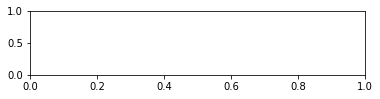

In [8]:
plt.subplot(3,1,1)
plt.plot(history.history['loss'])
plt.xlabel('epochs')
plt.ylabel('Total Loss')
plt.show()
plt.subplot(3,1,2)
plt.plot(history.history['localization_output_iou_metric'])
plt.xlabel('epochs')
plt.ylabel('IoU Metric')
plt.show()
plt.subplot(3,1,3)
plt.plot(history.history['classification_output_loss'])
plt.xlabel('epochs')
plt.ylabel('Cross Entropy Loss')
plt.show()

In [18]:
from sklearn import preprocessing
import numpy
le = preprocessing.LabelEncoder()
le.classes_ = numpy.load('classes.npy')

In [22]:
idx = np.random.randint(low=0,high=np.array(test_images).shape[0])
bb,classify = model.predict(np.expand_dims(np.array(test_images)[idx],0))
[[xmin,ymin,xmax,ymax]]= bb
img = cv2.rectangle(np.array(test_images)[idx], (xmin,ymin), (xmax,ymax), (0,255,0), 4)
pil_im = Image.fromarray(img)
a = np.argmax(classify,axis=1)[0]
label = le.inverse_transform(np.argmax(classify,axis=1))
#print(label[0])
#y = ymin - 15 if ymin - 15 > 15 else ymin + 15
plt.title("Predicted: "+label[0]+", Actual: "+le.inverse_transform(np.argmax(test_predictions[idx])))
plt.imshow(pil_im)
print(label[0])

/home/parmeet/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


IndexError: list index out of range

In [ ]:
f, axarr = plt.subplots(10)
f.set_figheight(50)
f.set_figwidth(100)
eq_list = np.array(labels_test)!=predicted_labels
eq_idx_list = [i for i, x in enumerate(eq_list) if x]
random.shuffle(eq_idx_list)
for idx,i in enumerate(eq_idx_list[0:10]):
    im = images[i]
    imag = normalize_image(im)
    #plt.imshow(imag)
    axarr[idx].imshow(imag)
    axarr[idx].title.set_text('Actual: '+np.array(labels_test)[i]+', Predicted: '+predicted_labels[i])
plt.show()

In [ ]:
f, axarr = plt.subplots(10)
f.set_figheight(50)
f.set_figwidth(100)
eq_list = np.array(labels_test)==predicted_labels
eq_idx_list = [i for i, x in enumerate(eq_list) if x]
random.shuffle(eq_idx_list)
for idx,i in enumerate(eq_idx_list[0:10]):
    im = images[i]
    imag = normalize_image(im)
    #plt.imshow(imag)
    axarr[idx].imshow(imag)
    axarr[idx].title.set_text('Actual: '+np.array(labels_test)[i]+', Predicted: '+predicted_labels[i])
plt.show()

In [19]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(labels_test, predicted_labels,labels=np.unique(labels_))
print(cm)

NameError: name 'labels_test' is not defined

In [ ]:
confusion_matrix(labels_test,predicted_labels)

labels_=list(np.unique(labels_test))
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels_)
ax.set_yticklabels([''] + labels_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [106]:
labels = 12
cnn_base = VGG16(input_shape=(224,224,3),include_top=False,weights='imagenet')

for layer in cnn_base.layers:
    if layer.name=='block5_conv3':
        break
    layer.trainable = False
x = cnn_base.get_layer('block5_pool').output

x = Conv2D(64, kernel_size=(3, 3), padding="same")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = BatchNormalization()(x)
x = Conv2D(64, kernel_size=(3, 3), padding="same")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = BatchNormalization()(x)
x = Conv2D(labels, kernel_size=(1, 1), padding="same")(x)
x = Reshape((labels,),name='localization_output')(x)


model = Model(inputs=cnn_base.input, outputs=x)

sgd = keras.optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss="mean_squared_error", optimizer="adam")
print(model.summary())
initial_weights = model.get_weights()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [107]:
for i in range(5):
    print("Loading file")
    with open('lobster-data-localize-landmarks-tangier'+str(i)+'.pckl','rb') as file:
        all_images,all_landmarks,test_images,test_landmarks = pickle.load(file)
    try:
        with open('lobster-landmarks_localization_vgg16_tangierv11'+str(i)+'.hd5','rb') as f:
            model_weights = pickle.load(f)
            print("loaded model")
    except:
        print("setting initial weights")
        model_weights = initial_weights
    model.set_weights(model_weights)
    print("loaded")
    print(np.max(test_images[0]))
    checkpoint = CustomModelCheckpoint('lobster-landmarks_localization_vgg16_tangierv11'+str(i)+'.hd5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True,mode='min')
    earlyStopping = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=12, verbose=0, mode='min', baseline=None, restore_best_weights=False)
    callbacks_list = [checkpoint,earlyStopping]
    history = model.fit(x=np.array(all_images),y=np.array(all_landmarks),batch_size=5,epochs=50,
                           validation_data=(np.array(test_images),np.array(test_landmarks)),callbacks=callbacks_list)
    history_record.append(history)
    train_score = model.evaluate(x=np.array(all_images),y=np.array(all_landmarks),batch_size=50)
    test_score = model.evaluate(x=np.array(test_images),y=np.array(test_landmarks),batch_size=50)
    train_scores.append(train_score)
    test_scores.append(test_score)

Loading file
setting initial weights
loaded
1.0
Train on 1206 samples, validate on 6 samples
Epoch 1/50
1206/1206 [==============================] - 18s 15ms/step - loss: 3122198.8425 - val_loss: nan

Epoch 00001: val_loss did not improve from inf
Epoch 2/50
 320/1206 [======>.......................] - ETA: 12s - loss: 2947555.5596

KeyboardInterrupt: 

In [112]:
test_landmarks

[array([180.32895952,  43.93055654, 187.74617807,  58.02327178,
         96.51438999,  91.40075522, 115.7991582 , 120.99545721,
         28.27597939, 139.61267575,  44.59386019, 167.79810621]),
 array([191.02767369, 112.82088247, 187.36275223, 128.28685105,
         97.20568416,  98.23449503,  94.27374699, 130.48580393,
         18.0433805 ,  90.9046521 ,  18.0433805 , 127.55386676]),
 array([ 44.77511594,  28.28471877,  60.57625803,  20.7603654 ,
         74.1200941 , 119.32939462, 107.22724896, 106.53799388,
        107.22724896, 200.59241108, 141.08683915, 184.03883365]),
 array([ 95.78349354,  18.1947209 , 111.22162941,  16.72442224,
         89.16714959, 110.82353613, 125.18946663, 110.82353613,
         91.37259757, 197.57115674, 125.92461595, 195.36570875]),
 array([116.06069776, 197.38645667,  98.04089578, 200.8518032 ,
        117.44683638, 110.059724  ,  86.95178687, 112.06962499,
        112.59535123,  37.28744677,  82.79337103,  39.99041707]),
 array([ 34.08693492, 175.8350